# TIME SERIES ANALYSIS

## HW11_eb3237

## INSTRUCTIONS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


//anaconda/envs/GEOP/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


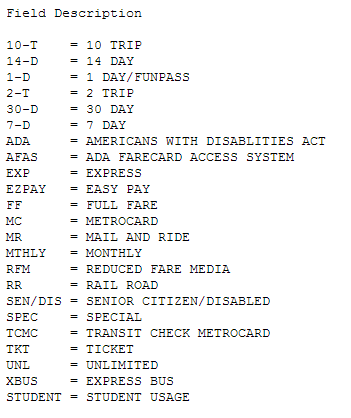

In [27]:
#from __future__ import print_function, division
#import pylab as pl
#import numpy as np
#import pandas as pd

#from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
#import statsmodels.api as sm

#%pylab inline

#from IPython.display import Image
#from IPython.display import clear_output
#pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

In [61]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import os
import json
import pylab as pl
from scipy import stats
import sklearn

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from sklearn.cross_validation import train_test_split

import statsmodels.formula.api as smf
from sklearn import ensemble


# read in data as instructed above

In [5]:
! curl -L https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy?raw=true > $PUIDATA/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   150  100   150    0     0    891      0 --:--:-- --:--:-- --:--:--   892
100 10.2M  100 10.2M    0     0  17.8M      0 --:--:-- --:--:-- --:--:-- 51.8M


In [6]:
mtaRides = np.load(os.environ["PUIDATA"] + '/MTA_Fare.npy')

In [7]:
#MTA array shape: 
mtaRides.shape

(600, 23, 194)

In [8]:
#MTA array shape summed over all ride types (time series for all stations)
mtaRides_sum = np.nansum(mtaRides,axis=1)
mtaRides_sum.shape

(600, 194)

create a "ride types" list based on the metadata I was given

In [9]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [10]:
#This is the information I recieved about the data: 
#each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks 
#from 05/19/2010 to 02/19/2014. "
date_s = pd.date_range("05/19/2010","02/19/2014", freq="w")
date_s

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-15', '2013-12-22', '2013-12-29', '2014-01-05',
               '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
               '2014-02-09', '2014-02-16'],
              dtype='datetime64[ns]', length=196, freq='W-SUN')

In [11]:
date_s.shape

(196,)

In [12]:
#the number of weeks above (196) does not correspond to the instructions
#so changing dates list to 194 weeks 

date_s1 = pd.date_range(start="05/21/2010", periods=194, freq='w')
date_s1.shape

(194,)

In [13]:
mtaRides_f = mtaRides.astype(float)

In [14]:
mtaRides_f[mtaRides_f == -1] = np.nan

In [15]:
len(mtaRides_f[0])

23

Text(0.5,1,' Time Series for all rids types and all stations in natural space')

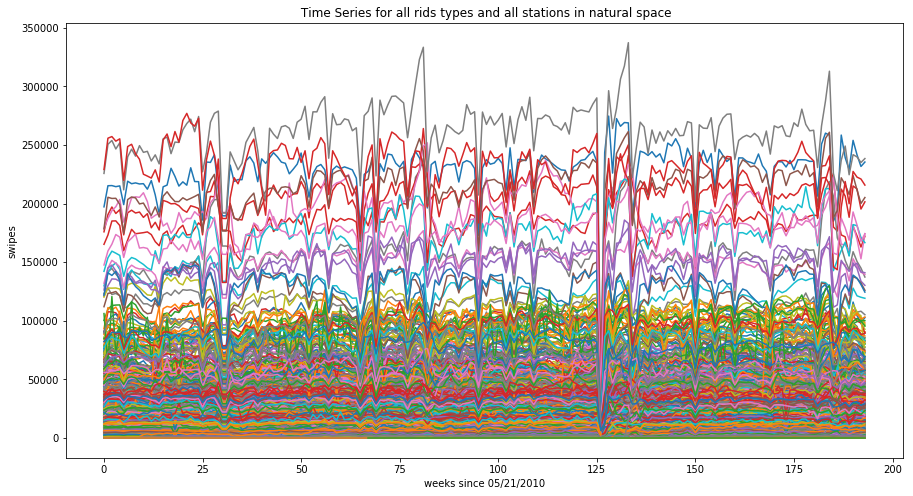

In [16]:
plt.figure(figsize=(15,8))
for i in range(len(mtaRides_f)):
    for j in range(len(mtaRides_f[i])):    
        plt.plot(mtaRides_f[i][j])
plt.xlabel('weeks since 05/21/2010')
plt.ylabel('swipes')
plt.title(' Time Series for all rids types and all stations in natural space')

Figure 1: Time Series for all ride types and all stations in natrual space.

Text(0.5,1,' Time Series for all rids types and all stations in semi-log space')

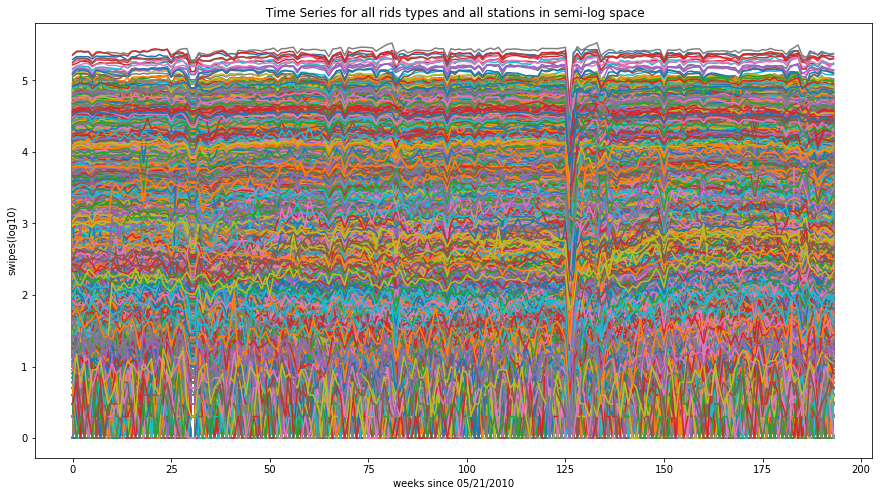

In [17]:
plt.figure(figsize=(15,8))
for i in range(len(mtaRides_f)):
    for j in range(len(mtaRides_f[i])):    
        plt.plot(np.log10(mtaRides_f[i][j]))

plt.xlabel('weeks since 05/21/2010')
plt.ylabel('swipes(log10)')
plt.title(' Time Series for all rids types and all stations in semi-log space')

Figure 2: Time Series for all rids types and all stations in semi-log space


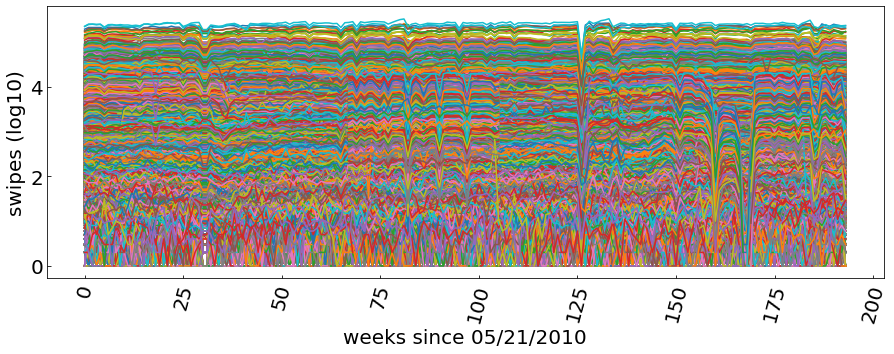

In [12]:
#EXAMPLE FROM THE TEACHER IS BELOW
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)


#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [18]:
#obtaining weekly swipes data for 600 stations, 194 weeks, 23 ticket types 

swipes_weeks = []

for i in range(194):
    x = []
    for n in range(600):
        for k in range(23):
            x.append(mtaRides[n][k][i])
    i = sum(x)
    swipes_weeks.append(i)
    
swipes_weeks

[26716631,
 29262313,
 29597575,
 29383978,
 29182176,
 26208052,
 28680022,
 29122010,
 28800200,
 28595932,
 28308361,
 27927423,
 27268131,
 28246743,
 26683582,
 30015142,
 30180176,
 29048486,
 30065000,
 29168839,
 30323454,
 30186700,
 29983681,
 30049876,
 30125402,
 25160821,
 29185649,
 30577220,
 30103021,
 27557647,
 21799403,
 21792798,
 27479553,
 27108970,
 26010345,
 26430220,
 28656503,
 29100353,
 29573058,
 26718018,
 29176634,
 29397046,
 29876972,
 29673828,
 29521768,
 30172126,
 30193061,
 28496477,
 29031851,
 30394695,
 29988635,
 29949834,
 27144981,
 29846497,
 30162349,
 29975652,
 30294451,
 26740659,
 29964051,
 29471983,
 29249492,
 29426206,
 29059658,
 27976524,
 27921014,
 22981394,
 28139307,
 31992892,
 32503085,
 24294628,
 32156059,
 30744539,
 32638048,
 32901236,
 31950684,
 32127913,
 32474319,
 27028024,
 31805789,
 33120126,
 33170696,
 31931091,
 24562552,
 28046492,
 30001277,
 28037318,
 29384138,
 31197426,
 31670476,
 31123474,
 28230517,

In [20]:
significant_drop = np.mean(swipes_weeks)-3*np.std(swipes_weeks)
print("significant drop > 3 std, is: {:.2f}".format(significant_drop))

significant drop > 3 std, is: 20825898.56


In [21]:
most_prominent_eventevent = np.where(swipes_weeks < significant_drop)
most_prominent_eventevent

(array([126]),)

So the most prominent eventevent occured on 126th week  of the data counting from 05/19/2010

In [22]:
#identifying the date
date_s1[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

So the date corresponds to Hurricane Sandy, more MTA flooding pictures here: https://gizmodoemergency.wordpress.com/2012/10/31/the-ultimate-gallery-of-flooded-nyc/

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


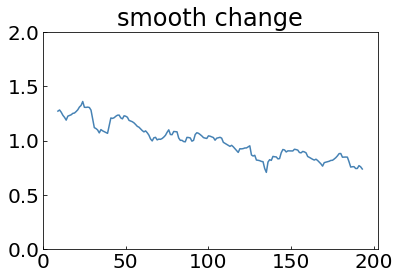

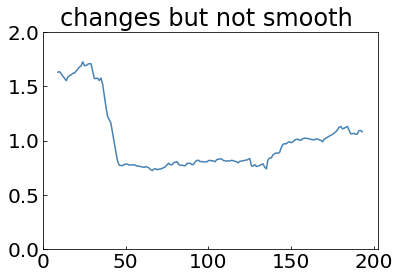

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [23]:
#23 Ride types- were given above - ridership type list 
#ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            #'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            #'umlim','xbus','stud'])

In [24]:
#MTA array shape summed over all stations 
mtaStation_sum = np.nansum(mtaRides,axis=0)
mtaStation_sum.shape

(23, 194)

In [35]:
ride_type = pd.DataFrame(mtaStation_sum)
ride_type.dropna(inplace = True)
ride_type.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,11494477,12526720,12766490,12653538,12809558,11429646,12346741,12576621,12436978,12431120,...,14603889,11344807,11223293,12864727,12904674,11932832,13139222,13189472,12500619,12459809
1,530386,583394,586057,562465,548722,455554,518051,513274,512055,522432,...,781390,596203,518819,664393,744853,613156,713579,694996,670091,679359
2,47663,51347,51499,51926,51017,46715,48827,49491,48893,50239,...,62519,50682,45016,55991,60292,51526,57070,58633,56388,55054
3,186413,199090,199531,196252,194747,175511,188331,187952,186685,190391,...,193129,164469,148515,177747,193410,168794,189426,184101,179892,179225
4,46670,64214,56857,37292,35074,46712,60089,47301,31947,52034,...,56532,22485,25164,67575,64730,43288,47666,60963,59263,46721


In [37]:
ride_type_rmean = ride_type.rolling(window = 10, axis=1).sum() / 3

In [38]:
ride_type_rmean.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.115730e+07,...,4.508512e+07,4.440938e+07,4.360465e+07,4.337690e+07,4.309144e+07,4.261552e+07,4.252118e+07,4.306123e+07,4.264944e+07,4.205445e+07
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.777463e+06,...,2.560724e+06,2.505196e+06,2.416461e+06,2.380888e+06,2.361065e+06,2.306203e+06,2.278933e+06,2.307135e+06,2.262588e+06,2.225613e+06
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.658723e+05,...,2.085563e+05,2.045617e+05,1.984010e+05,1.961097e+05,1.940793e+05,1.904050e+05,1.882370e+05,1.903553e+05,1.874660e+05,1.843903e+05
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.349677e+05,...,6.592050e+05,6.479363e+05,6.289170e+05,6.204920e+05,6.162823e+05,6.059123e+05,6.014063e+05,6.059173e+05,5.990763e+05,5.929027e+05
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.593967e+05,...,1.840520e+05,1.733197e+05,1.653590e+05,1.722990e+05,1.720940e+05,1.654890e+05,1.631103e+05,1.732990e+05,1.716733e+05,1.647957e+05


Text(0,0.5,'number of swipes')

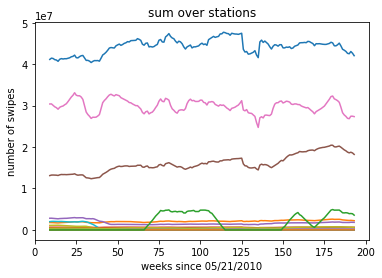

In [39]:
for i in range(23):
    plt.plot(ride_type_rmean.iloc[i])
plt.title('MTA rolling mean for 194 weeks by card type')
plt.xlabel('rides since 05/21/2010')
plt.ylabel('number of swipes')

Figure 3. plot of number of swipes per ride_type(sum over stations) against weeks

In [40]:
for i in range(23):
    print(ride_type_rmean.iloc[i,193]/ride_type_rmean.iat[i,9])

1.02179811957
1.25212878278
1.11164007661
0.933752532281
1.03387147368
1.38976104315
0.899839768514
-0.0124952739278
-0.000410248577647
-0.000228516487323
0.818182923656
1.21375837271
-1092.95890411
0.578296607154
0.649550753646
2.59634538078
2.91780866005
100.142045455
1.53287100927
1.02170154188
0.804934428503
1.92861356932
-1780.66966667


### to identify a ride type that has a steepest increase, the the ratio of end to beginning should has the largest value. 
### Infinite value here is due to the denominator being 0, which should be ruled out. 

Text(0,0.5,'number of swipes')

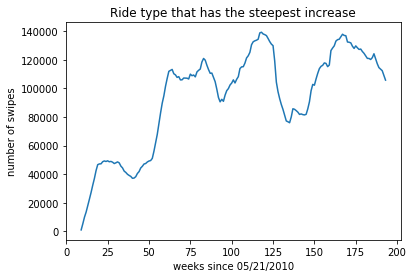

In [41]:
plt.plot(ride_type_rmean.iloc[17])
plt.title('Ride type that has the steepest increase')
plt.xlabel('weeks since 05/21/2010')
plt.ylabel('number of swipes')

Figure 4. Plotting the number of swipes per ride type(sum over stations) against weeks that has the steepest increase.

Text(0,0.5,'number of swipes')

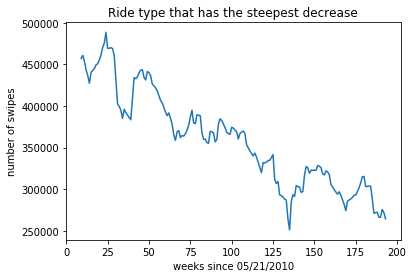

In [42]:
plt.plot(ride_type_rmean.iloc[13])
plt.title('Ride type that has the steepest decrease')
plt.xlabel('weeks since 05/21/2010')
plt.ylabel('number of swipes')

Figure 5. Plotting the number of swipes per ride type(sum over stations) against weeks that has the steepest decrease.

In order to identify a steepest decrease, we calculate the ratio of end to beginning should has the smallest value.
0.000146254424196 here is ruled out because it has no structure

Text(0,0.5,'number of swipes')

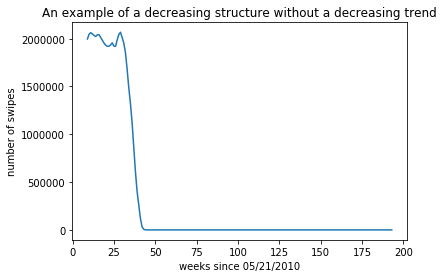

In [44]:
plt.plot(ride_type_rmean.iloc[9])
plt.title('An example of a decreasing structure without a decreasing trend')
plt.xlabel('weeks since 05/21/2010')
plt.ylabel('number of swipes')

Figure 6. Plotting the number of swipes per ride type(sum over stations) against weeks that has the steepest decrease.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [ ]:
#a sabove, mtaRides_f = mtaRides.astype(float)
#just change names

## Model 1: 
###  The first feature is the mean of that one time series compared to the mean of any time series in that station.
 ### The second feature is the std of that time series / std of any time series in that station
 ### The third feature is the intercept of the line fit
 
 ### The fourth feature is the Coefficient of the line.

loop over each time_series, use the ticket type as a label

In [45]:
station_card_type_week = []
for station in range(len(mtaRides_f)):
    for card_type in range(len(mtaRides_f[station])):
        station_card_type_week.append([list(mtaRides_f[station][card_type])] + [station, card_type])

created features

In [46]:
# clean the time series
station_card_type_week_cleaned = []
for i in range(len(station_card_type_week)):
    count = 0
    for num in station_card_type_week[i][0]:
        num = str(num)
        if num == 'nan':
            count = 1
    if count == 0:
        station_card_type_week_cleaned.append(station_card_type_week[i])

In [47]:
# group by station name
denominator = {}
for i in range(len(station_card_type_week_cleaned)):
    time_series = station_card_type_week_cleaned[i][0]
    station = station_card_type_week_cleaned[i][1]
    card_type = station_card_type_week_cleaned[i][2]
    if station in denominator:
        denominator[station] = denominator[station] + time_series 
    else:
        denominator[station] = time_series

In [48]:
## denominatoer[station] is now all the time series in aspecific station.
#(All card type added together)

In [51]:
model_data = []
standardizedts = []
for i in range(len(station_card_type_week_cleaned)):
    time_series = station_card_type_week_cleaned[i][0]
    station = station_card_type_week_cleaned[i][1]
    card_type = station_card_type_week_cleaned[i][2]
    numerator_mean = np.mean(time_series)
    numerator_std = np.std(time_series)
    feature_1 = numerator_mean / np.mean(denominator[station])
    feature_2 = numerator_std / np.std(denominator[station])
    ## standardizedts is standardized time series.
    standardizedts.append((time_series -  np.mean(time_series)) / np.std(time_series))
    time_series = pd.DataFrame(time_series)
    time_series.rename(columns={0:'rides'}, inplace = True)
    time_series['week'] = time_series.index + 1
    feature_3 = smf.ols(formula = 'rides ~ week', data = time_series).fit().params.Intercept
    feature_4 = smf.ols(formula = 'rides ~ week', data = time_series).fit().params.week
    model_data.append([feature_1, feature_2, feature_3, feature_4, station, card_type])

Text(0,0.5,'standardized number of rides')

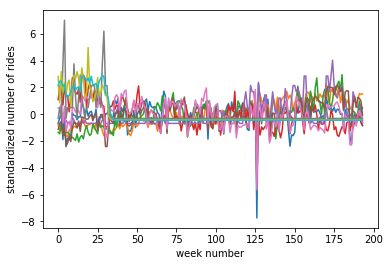

In [52]:
for i in range(10):
    plt.plot(standardizedts[i])
plt.xlabel("week number")
plt.ylabel("standardized number of rides")

### Figure 7. plot of the first 10 standardized time series.

When calculating the feature, I am not using the standardized time series because it is possible that there exists two type of cards having similar trends. If we standardize them, it would be hard to seperate them.

In [53]:
model = pd.DataFrame(model_data)

In [54]:
model.rename(columns = {0:'mean',1:'std', 2:'Intercept',3:'Coefficient',4:'Station',5:'card_type'
                       }, inplace = True)

In [55]:
model.head()

,mean,std,Intercept,Coefficient,Station,card_type
0,11.270647,0.469495,3545.193686,0.038193,2,0
1,0.459181,0.052300,80.503071,0.657278,2,1
2,0.056968,0.009761,9.148870,0.090146,2,2
3,0.096092,0.011767,40.835052,-0.108485,2,3
4,0.009200,0.005080,-1.482346,0.044915,2,4


Split the training and test data (67%/33%)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(model[['mean','std','Intercept','Coefficient']],
                                        model['card_type'], random_state = 42, train_size = 0.67)

In [57]:
np.array(x_train).shape, np.array(x_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6146, 4), (3028, 4), (6146,), (3028,))

In [ ]:
np.array(x_train).shape, np.array(x_test).shape, np.array(y_train).shape, np.array(y_test).shape

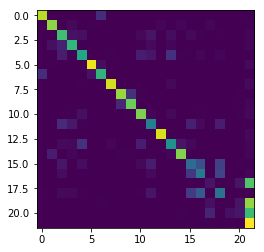

In [82]:
#Build and test a random forest model that predicts the ticket type based on 4 engineered features
clf =  ensemble.RandomForestClassifier()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)
imshow(confusion_matrix(y_test, y_test_pred))

Figure 9. Confusion matrix of the model with 4 features

In [63]:
print(sklearn.metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.88      0.85      0.86       151
          1       0.86      0.90      0.88       134
          2       0.63      0.75      0.68       139
          3       0.79      0.78      0.78       126
          4       0.70      0.58      0.63       146
          5       0.95      0.93      0.94       154
          6       0.78      0.83      0.81       123
          7       0.98      0.96      0.97       146
          8       0.89      0.84      0.87       147
          9       0.85      0.87      0.86       134
         10       0.84      0.89      0.87       137
         11       0.54      0.58      0.56       123
         12       0.98      0.98      0.98       142
         13       0.70      0.64      0.67       130
         14       0.90      0.84      0.87       140
         15       0.47      0.38      0.42       146
         16       0.38      0.41      0.39       125
         17       0.24      0.06      0.10   

In [83]:
feature_importances = pd.DataFrame(clf.feature_importances_,index = x_train.columns,columns=['importance']).sort_values('importance',ascending=False)

In [84]:
feature_importances_

NameError: name 'feature_importances_' is not defined

The top 2 important feature in this model is mean and coefficient.

## Model 2:  Build and test a random forest model that predicts the ticket type based on all datapoint in the time series

reshape the data set in a for loop

In [68]:
model_2 = []
for i in range(len(station_card_type_week_cleaned)):
    time_series = station_card_type_week_cleaned[i][0]
    station = station_card_type_week_cleaned[i][1]
    card_type = station_card_type_week_cleaned[i][2]
    time_series.append(station)
    time_series.append(card_type)
    model_2.append(time_series)

In [69]:
model_2 = pd.DataFrame(model_2)
model_2.rename(columns = {194:'station',195:'card_type'}, inplace = True)
model_2.head()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,station,card_type
0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,2,0
1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0,2,1
2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0,2,2
3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0,2,3
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0,2,4


In [70]:
#train test split
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(model_2[[i for i in range(194)]],
                                        model_2['card_type'], random_state = 42, train_size = 0.67)

In [71]:
np.array(x_train_2).shape, np.array(x_test_2).shape, np.array(y_train_2).shape, np.array(y_test_2).shape

((6146, 194), (3028, 194), (6146,), (3028,))

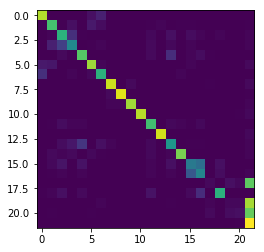

In [73]:
clf_2 =  ensemble.RandomForestClassifier()
clf_2.fit(x_train_2, y_train_2)
y_test_pred_2 = clf_2.predict(x_test_2)
imshow(confusion_matrix(y_test_2, y_test_pred_2))

Figure 10. Confusion matrix of the model with 194 features

In [74]:
feature_importances_2 = pd.DataFrame(clf_2.feature_importances_,index = x_train_2.columns,
                                     columns=['importance']).sort_values('importance',ascending=False)

In [75]:
feature_importances_2

,importance
13,0.022096
61,0.016819
6,0.016658
21,0.016093
8,0.015693
32,0.015234
11,0.015115
35,0.014222
9,0.013334
94,0.012858


The top 2 important feature in this model is 13th and 34th week.

In [76]:
print(sklearn.metrics.classification_report(y_test_2, y_test_pred_2))

             precision    recall  f1-score   support

          0       0.80      0.87      0.84       151
          1       0.74      0.78      0.76       134
          2       0.61      0.69      0.65       139
          3       0.62      0.56      0.59       126
          4       0.74      0.75      0.75       146
          5       0.84      0.82      0.83       154
          6       0.76      0.78      0.77       123
          7       0.94      0.94      0.94       146
          8       0.99      0.97      0.98       147
          9       0.97      0.96      0.96       134
         10       1.00      0.97      0.99       137
         11       0.78      0.85      0.81       123
         12       0.99      0.98      0.98       142
         13       0.65      0.60      0.62       130
         14       0.96      0.85      0.90       140
         15       0.50      0.41      0.45       146
         16       0.45      0.54      0.49       125
         17       0.33      0.03      0.06   

### Discuss: 
The model with 194 features predicts slightly better than the model with 4 features.
The confusion matrix look similar to that of the first model.

Text(0, 0.5, 'standardized number of rides')

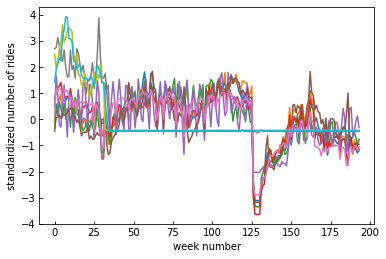

In [25]:
#standardizedts = ...
#for i in range(10):
    #pl.plot(standardizedts[i])
#pl.xlabel("week number")
#pl.ylabel("standardized number of rides")